# ASL Alphabet Classifier Test #1

#### Datasource: 
<a href="https://www.kaggle.com/grassknoted/asl-alphabet">https://www.kaggle.com/grassknoted/asl-alphabet</a>

<br>

This is a prototype, playing with FastAI using Resnet101 to classify American Sign Language alphabet.  It's basically Notebook #2 from the MOOC on a "clean" dataset.  We get great results ... but the data is really contrived.  It's highly likely the model will be overfitted, however it's a good test of the library.
<br>
<br>
<br>

In [10]:
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *
import fastai
import mlflow.fastai

plt.style.use('classic')


In [11]:
path = '../data/external/Training Set'

<br>

### Create the DataBlock

In [12]:
signs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label)

# learn_inf = load_learner('../models/export-resnet101-tune10un-tune2ft.pkl')



<br>

## Resize and add basic image augmentation

In [13]:
# signs = signs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
signs = signs.new(item_tfms=Resize(300, method=ResizeMethod.Squish))

# signs.apply_tfms(Image.flip)


<br>

### Load the data by path

In [14]:
dls = signs.dataloaders(path)


<br>

### Verify the Training and Validation Batches

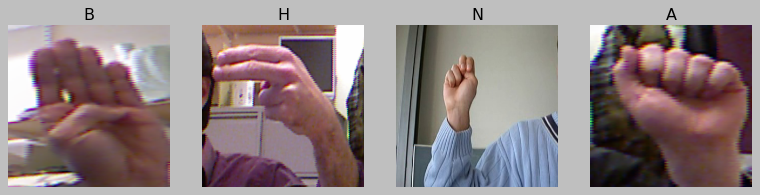

In [6]:
dls.train.show_batch(max_n=4, nrows=1)

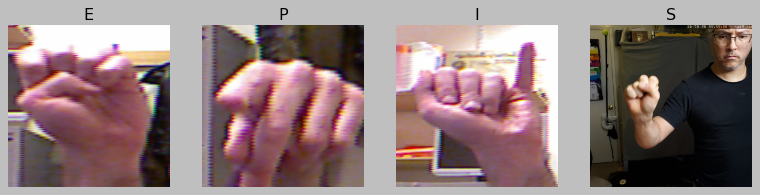

In [7]:
dls.valid.show_batch(max_n=4, nrows=1)

<br>

### Define the model (Resnet101) and fit

In [15]:
learn = cnn_learner(dls, resnet34 , metrics=error_rate, pretrained=False)

<br>
<br>
<br>

## Manually find a learning rate between the shoulder and the steepest drop.

In [ ]:
lr_min,lr_steep = learn.lr_find()


In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

## Fit the whole network since we are starting without a pretrained model

In [11]:

learn.fit(10, 3e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.476455,0.525611,0.165343,10:15
1,0.204864,0.207079,0.062738,10:04
2,0.087860,0.080658,0.025942,10:04
3,0.076183,0.048699,0.015195,10:08
4,0.043638,0.042866,0.012971,10:06
5,0.044552,0.033100,0.009159,10:02
6,0.020250,0.030453,0.009106,10:02
7,0.020577,0.021007,0.005612,10:03
8,0.033427,0.049876,0.014401,10:02
9,0.021508,0.027509,0.007147,10:03


In [ ]:
learn.unfreeze()
learn.fine_tune(2, base_lr=1e-5)


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(30, 1e-5)

<br>
<br>
<br>

## Fit the last layer to our data

In [ ]:
learn.fit_one_cycle(4, 1e-5)

<br>
<br>
<br>

## Unfreeze the rest of the layers and find a new learning rate for the whole net.

In [15]:
learn.freeze()

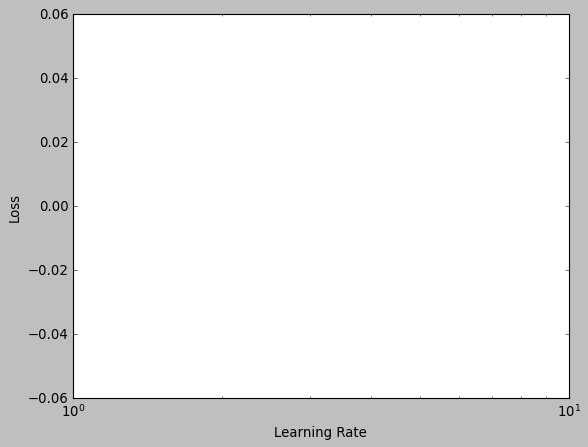

In [16]:
learn.lr_find()

In [17]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.014554,0.020299,0.004500,06:59


epoch,train_loss,valid_loss,error_rate,time
0,0.002783,0.011009,0.002277,10:00


<br>
<br>
<br>

## Fit the whole network at an appropriate learning rate

In [ ]:
learn.fit_one_cycle(2, lr_max=5e-5)

In [ ]:
learn.fit_one_cycle(2, lr_max=5e-5)

In [ ]:
learn.recorder.plot_loss()

<br>

### Visualize with a confusion Matrix

In [3]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

NameError: name 'learn' is not defined

<br>

### Show the top 5 most error prone images

In [ ]:
interp.plot_top_losses(15, nrows=3)

In [2]:
losses, idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

NameError: name 'interp' is not defined

<br>
<br>
<hr>
<br>
<br>

## Persist the Model

<br>
<br>

In [18]:
learn.export('../models/200922-1813-FALL-NOPRETRAIN-10fit-2ft')
path = Path('../models')
path.ls(file_exts='.pkl')

(#5) [Path('../models/export-resnet101-FALL-tune2ft-tune10un-tune2ft.pkl'),Path('../models/export-resnet101-F-tune2ft-tune10un-tune2ft.pkl'),Path('../models/export-resnet101-tune10un-tune2ft.pkl'),Path('../models/200921-0235-RN101-ALL-ut10-f2ft-F-f2ft.pkl'),Path('../models/200921-0121-export-resnet101-FALL-tune2ft-tune6un-tune2ft.pkl')]

In [ ]:
%cd ..
learn_inf.save('save/200921-0201-export-resnet101-FALL-tune2ft-tune6un-tune2ft-F-t2ft-ut3-t2ft-t2ft')
%cd notebooks

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('../data/raw/darktable_exported/D-frank.jpg')

In [ ]:
learn_inf.predict('../data/raw/darktable_exported/aA2.jpg')

In [ ]:
learn_inf.dls.vocab

In [ ]:
pred,pred_idx,probs = learn_inf.predict('../data/raw/darktable_exported/aA2.jpg')

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
pred,pred_idx,probs = learn_inf.predict('../data/raw/darktable_exported/D-frank.jpg')

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

<br>
<br>

## Make a Notebook App

<br>

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
# with out_pl: display(img.to_thumb(200,200))
# out_pl

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(200,200))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)

In [ ]:
VBox([widgets.Label('Select an image: '),
    btn_upload, btn_run, out_pl, lbl_pred])